In [1]:
%pylab inline
import radvel

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


/Users/bjfulton/anaconda3/lib/python3.6/site-packages/emcee-2.2.1-py3.6.egg/emcee/ptsampler.py:36: DeprecationWarning: invalid escape sequence \e
/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py:60: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py' mode='r' encoding='utf-8'>
  class X(object):
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args,

Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

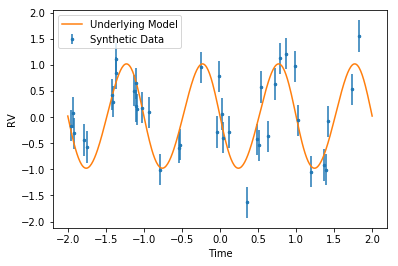

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + randn(t.size)*np.sqrt(errvel**2 + jitter**2)
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 1.04167512, -0.02067616,  0.46923961, -0.10014729,  0.97684989,
         0.00943079,  0.0425074 ,  0.03584794],
       [ 1.04164993, -0.02042148,  0.46839095, -0.09948685,  0.97645307,
         0.00943048,  0.04238043,  0.03574607],
       [ 1.04158   , -0.02047384,  0.46866301, -0.09973657,  0.9775711 ,
         0.00946204,  0.04232837,  0.03570133],
       [ 1.04157882, -0.02038494,  0.46819583, -0.10057329,  0.97704907,
         0.00939581,  0.04235182,  0.03568744],
       [ 1.04166133, -0.0203787 ,  0.46828913, -0.09936948,  0.97614325,
         0.00940051,  0.04244209,  0.03579687],
       [ 1.04168102, -0.02081351,  0.46933381, -0.09986921,  0.97730145,
         0.009473  ,  0.04246687,  0.03583052],
       [ 1.04159215, -0.0206823 ,  0.46902931, -0.10021928,  0.97671215,
         0.00950903,  0.04227662,  0.03565684],
       [ 1.04164047, -0.02036108,  0.46790101, -0.10177136,  0.97683857,
         0.00941164,  0.04217649,  0.03550519],
       [ 1.0416

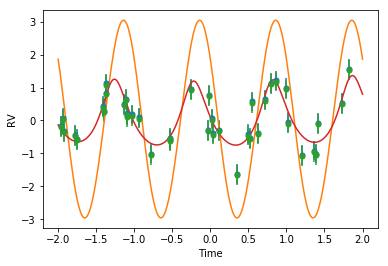

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [8]:
post = radvel.posterior.Posterior(like_syn)
post.params.update(dict(per1=radvel.Parameter(value=1),
                        k1=radvel.Parameter(value=1)))
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)

parameter                     value      vary
per1                              1       True
tc1                      -0.0208151       True
secosw1                    0.469852       True
sesinw1                   -0.100049       True
k1                                1       True
dvdt                     0.00940399       True
curv                      0.0427002       True
gamma                     0.0360188       True
jit                             0.3       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Perform maximum likelihood fit on posterior
=========================================

/Users/bjfulton/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


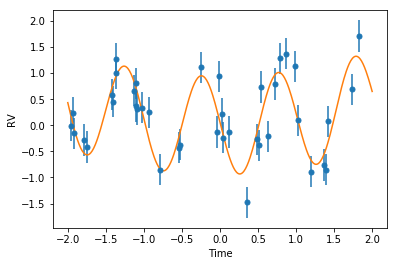

In [9]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Powell' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [10]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 23172.01 steps/s; Mean acceptance rate = 49.0%; Min Tz = 2244.9; Max G-R = 1.012      
Discarding burn-in now that the chains are marginally well-mixed

160000/160000 (100.0%) steps complete; Running 22711.09 steps/s; Mean acceptance rate = 40.1%; Min Tz = 2550.3; Max G-R = 1.011      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


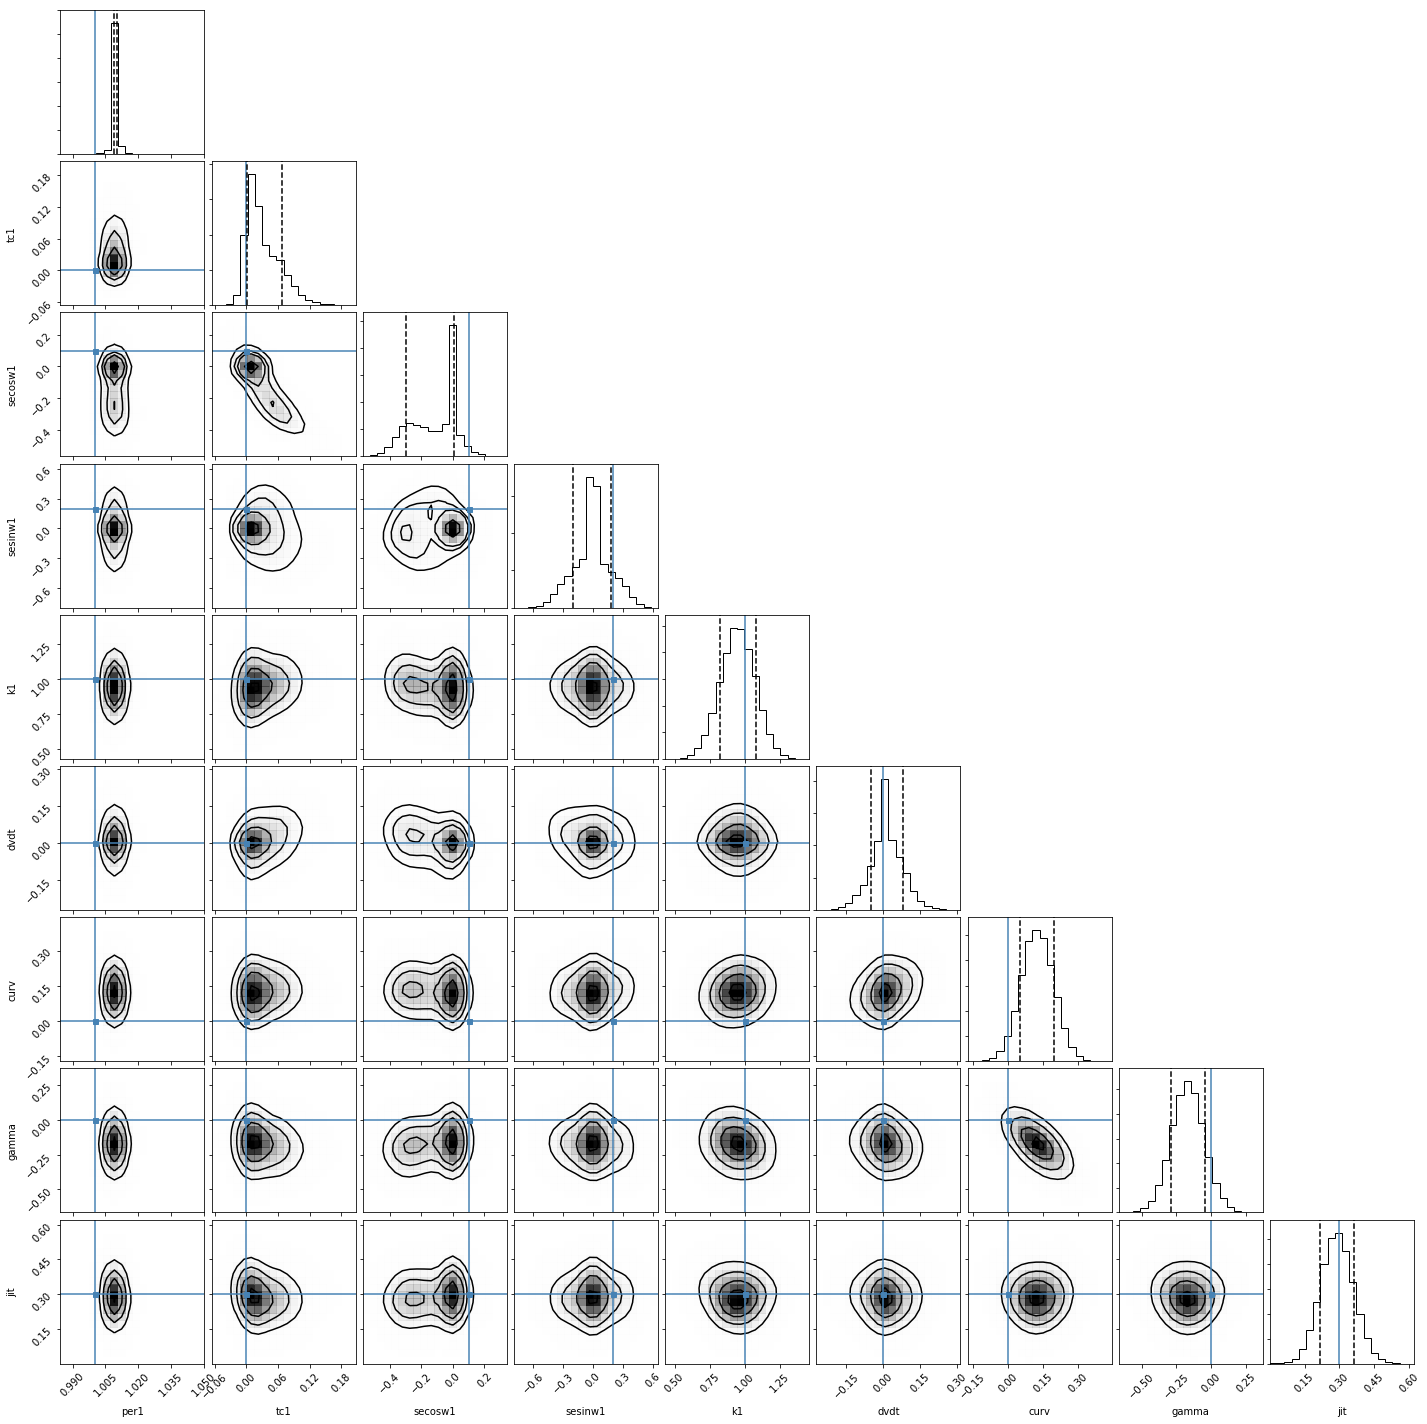

In [11]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

(array([1.5000e+01, 4.6000e+01, 2.7000e+02, 9.7600e+02, 3.5790e+03,
        1.2272e+04, 3.2089e+04, 5.3015e+04, 4.0157e+04, 9.5810e+03]),
 array([-31.49532052, -29.27958208, -27.06384364, -24.8481052 ,
        -22.63236676, -20.41662832, -18.20088988, -15.98515145,
        -13.76941301, -11.55367457,  -9.33793613]),
 <a list of 10 Patch objects>)

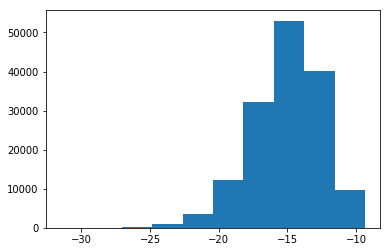

In [12]:
hist(df.lnprobability)